# Counting features in satellite images using scikit-image

The example below uses scikit-image library to detect circular features in farms using center pivot irrigation in Saudi Arabia. It then counts and reports the number of farms. This is one of the ways in which libraries from the scientific Python ecosystem can be integrated with the ArcGIS platform.

It uses the Multispectral Landsat imagery available at ArcGIS Online.

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
conda install scipy
conda install matplotlib
conda install scikit-image
```

In [1]:
from arcgis.gis import GIS
from arcgis.raster.functions import ndvi, stretch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import feature, color

In [2]:
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
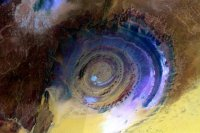

In [3]:
l8 = gis.content.search('"Multispectral Landsat"', 'Imagery Layer', outside_org=True)[0]
l8

In [4]:
l8lyr = l8.layers[0]

The code below sets the extent of the layer, to a known extent of farms in Saudi Arabia and then visualizes the landsat layer.

In [5]:
m1 = gis.map('Al Jouf, Saudi Arabia', 9)
m1

MapView(layout=Layout(height='400px', width='100%'))

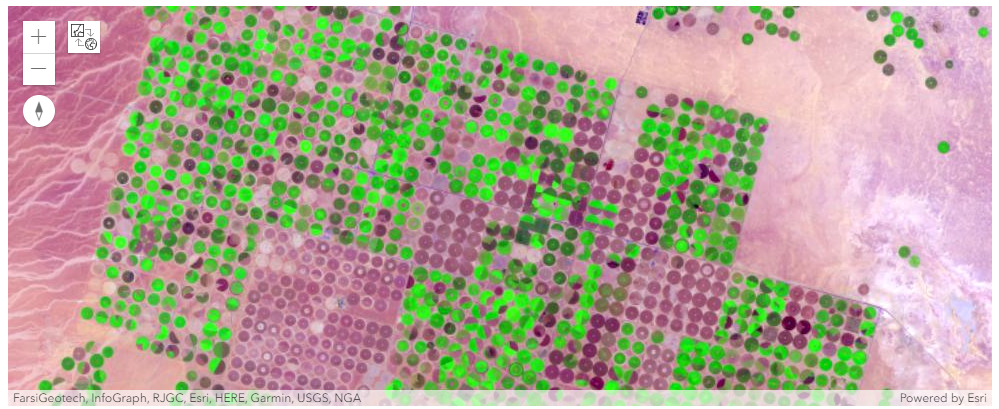

In [6]:
m1.add_layer(l8lyr)

After loading the map, pan and zoom-in in the farms and set the extent of the study area for the further analysis.

In [7]:
m1.extent

{'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': 4227028.402944782,
 'ymin': 3509950.402192058,
 'xmax': 4302242.438777293,
 'ymax': 3540525.2135060877}

In [8]:
l8lyr.extent = m1.extent
l8lyr.extent

{'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': 4227028.402944782,
 'ymin': 3509950.402192058,
 'xmax': 4302242.438777293,
 'ymax': 3540525.2135060877}

We can preprocess the imagery using raster functions. The code below uses the ndvi raster function to identify areas that have healthy vegetation. This preprocessing step makes the scikit-image blob detection algorithm work better.

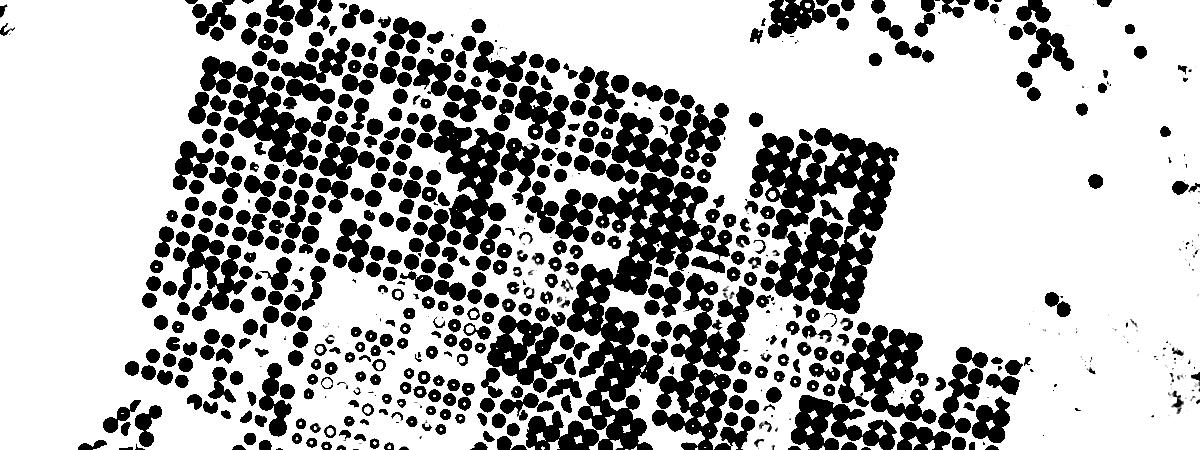

In [9]:
stretch(ndvi(l8lyr), stretch_type='PercentClip', min_percent=30, max_percent=70, dra=True)

The code below exports the imagery to a file from which we read it using matplotlib's image API and plot it:

In [10]:
img = stretch(ndvi(l8lyr), 
              stretch_type='PercentClip', 
              min_percent=30, 
              max_percent=70, 
              dra=True).export_image(bbox=l8lyr.extent, 
                                     bbox_sr=102100, 
                                     size=[1200, 450],
                                     export_format='jpeg', 
                                     save_folder='.', 
                                     save_file='centerpivotfarms.jpg', 
                                     f='image')

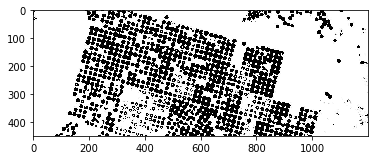

In [11]:
img = mpimg.imread('centerpivotfarms.jpg')

# what does it look like?
plt.imshow(img)
plt.show()

## Blob detection using scikit-image

The code below uses scikit-image library to find blobs in the given grayscale image, and reports the number of farms thus detected. It also plots them for visualization using matplotlib.

Blobs are found using the [Difference of Gaussian (DoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog) method.

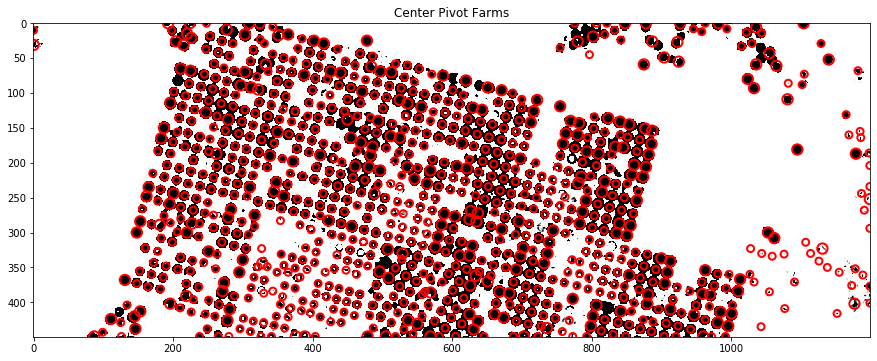

Number of center pivot farms detected: 936


In [12]:

bw = img.mean(axis=2)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)

blobs_dog = [(x[0],x[1],x[2]) for x in feature.blob_dog(-bw, 
                                                        min_sigma=4, 
                                                        max_sigma=8,
                                                        threshold=0.1,
                                                        overlap=0.6)]

#remove duplicates
blobs_dog = set(blobs_dog)

img_blobs = color.gray2rgb(img)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.imshow(img_blobs)
plt.title('Center Pivot Farms')

plt.show()
print('Number of center pivot farms detected: ' + str(len(blobs_dog)))